# Question 1
#### 1.3)

In [40]:
def create_matrix(x):
    n,_ = A.shape
    mat = np.zeros((n,n))
    lst = []
    for a_i,b_i in zip(A,b):
        lst.append(1/(a_i.dot(x) - b_i)**2)    
    np.fill_diagonal(mat,lst)
    return mat

In [41]:
def analytic_center(A, b, x0):
    import numpy as np
    from numpy import log
    s, alpha, beta = 2, 0.25, 0.5
    if sum(np.less(A@x0,b)) == len(b):
        pass
    else:
        raise ValueError("x0 not in range")
    n = x0.shape[0]
    f_help = lambda b_i,a_i,x: np.log(b_i - a_i.dot(x))
    f = lambda x: - np.sum(np.array([f_help(b_i,a_i,x) for b_i, a_i in zip(b,A)]))
    gf = lambda x: A.T @ np.array([-1/(a_i.dot(x) - b_i) for a_i, b_i in zip(A,b)])
    hf = lambda x: A.T @ create_matrix(x) @ A
    xs = np.array(x0.T)
    fs = [f(x0)]
    x_k = x0
    while np.linalg.norm(gf(x_k)) >= 1e-6:
        d_k = np.linalg.solve(hf(x_k), -gf(x_k))
        t_k = s
        while f(x_k + t_k * d_k) >= f(x_k) + alpha * t_k * (gf(x_k).T @ d_k)[0][0]:
            t_k = beta * t_k
        x_k = x_k + t_k * d_k
        fs.append(f(x_k))
        xs = np.vstack((xs,x_k.T[0]))
    return xs.T, fs

In [42]:
import numpy as np
A = np.array([[2,10],[1,0],[-1,3],[-1,-1]])
b = np.array([[1],[0],[2],[2]])
a,b = analytic_center(A,b,np.array([[-1.99],[0]]))

# Question 2
#### 2.1)

In [122]:
def hybrid_newton(f,gf,hf,lsearch,x0,eps):
    from time import time
    fs = []
    gs = []
    ts = []
    newton = []
    start = time()
    x_k = x0
    while np.linalg.norm(gf(*x_k)) >= eps:
        fs.append(f(*x_k))
        gs.append(np.linalg.norm(gf(*x_k)))
        ts.append(time()-start)
        try:
            np.linalg.cholesky(hf(*x_k))
            d_k = np.linalg.solve(hf(*x_k), - gf(*x_k))
            t_k = lsearch(x_k, gf(*x_k), [d_k, 'newton'])
            x_k += t_k * d_k
            newton.append(1)
        except:
            d_k = -gf(*x_k)
            t_k = lsearch(x_k, gf(*x_k), [d_k, 'grad'])
            x_k = x_k + t_k * d_k
            newton.append(0)
    fs = np.array(fs)
    gs = np.array(gs)
    return x_k, fs, gs, ts, newton

#### 2.2)

In [123]:
def hybrid_back(f, alpha, beta, s):
    def lsearch(x_k, g_k, direction):
        if direction[1] == 'grad':
            t_k = s
            while f(*(x_k - t_k * g_k)) >= f(*x_k) - alpha * t_k * np.linalg.norm(g_k) ** 2:
                t_k *= beta 
            return t_k
        else:
            return 1
    return lsearch

#### 2.3)

In [130]:
def generic_grad(f, gf, lsearch, x0, eps):
    from time import time
    fs = []
    gs = []
    ts = []
    start = time()
    x_k = x0
    fs.append(f(*x_k))
    gs.append(np.linalg.norm(gf(*x_k)))
    ts.append(time()-start)
    while True:
        t = lsearch(f, x_k, gf(*x_k))
        x_k_1 = x_k - t * gf(*x_k)
        fs.append(f(*x_k_1))
        gs.append(np.linalg.norm(gf(*x_k_1)))
        ts.append(time()-start)
        if np.linalg.norm(gf(*x_k)) < eps:
            break
        x_k = x_k_1
    fs = np.array(fs)
    gs = np.array(gs)
    
    return x_k_1, fs, gs, ts

In [131]:
def back(alpha, beta, s):
    if alpha <= 0 or beta <= 0 or alpha >= 1 or beta >= 1 or s <= 0:
        raise ValueError("Incompatible values.")

    def inner_func(f, xk, gk):
        t = s
        while f(*(xk - t * gk)) >= f(*xk) - alpha * t * np.linalg.norm(gk) ** 2:
            t *= beta
        return t

    return inner_func

In [132]:
alpha = 0.25
s = 1
beta = 0.5
f = lambda x,y: float(x**4) + float(y**4) - float(36*x*y)
gf = lambda x,y: np.array([4 * x**3 - 36 * y, 4 * y**3 - 36 * x], dtype = 'float')
hf = lambda x,y: np.array([[12 * x**2, -36],[-36, 12 * y**2]], dtype = 'float')

x1, fs1, gs1, ts1, newton = hybrid_newton(f,gf,hf,hybrid_back(f,alpha,beta,s),np.array([200,0]),1e-6)
x2, fs2, gs2, ts2 = generic_grad(f,gf, back(alpha, beta, s), np.array([200,0]),1e-6)

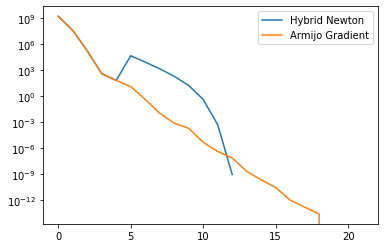

In [137]:
import matplotlib.pyplot as plt
plt.semilogy(fs1+162, label="Hybrid Newton")
plt.semilogy(fs2+162, label="Armijo Gradient")
plt.legend()
plt.show()